# Setup

**THINGS TO FIX**:
- fix double `'role': 'system',`
- 

In [4]:
import pandas as pd
import numpy as np

import json
import matplotlib.pyplot as plt
import datetime
from datasets import Dataset

# Transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

In [5]:
# Set API Keys
from kaggle_secrets import UserSecretsClient # API Loggins
user_secrets = UserSecretsClient()

## Hugging Face
Hugging_Face_token = user_secrets.get_secret("Hugging_Face_token")

# Login to Hugging Face
from huggingface_hub import login

login(Hugging_Face_token)

# Load Data

In [6]:
#df_HoC_2000s_raw = pd.read_csv('H:/MA_Thesis/data/Rauh_Schwalbach_2020_ParlSpeech/df_HoC_2000s.csv')

df_HoC_2000s_raw = pd.read_csv('/kaggle/input/parlspeech/df_HoC_2000s.csv')
df_HoC_2000s_raw.columns

df_HoC_2000s = df_HoC_2000s_raw[['date', 'agenda', 'speechnumber', 'speaker', 'party','text']]

In [ ]:
#df_HoC_2000s.columns
#df_HoC_2000s.head(3)

# Load Tokenizer

In [7]:
BASE_MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

In [8]:
# Create the tokenizer to measure the length of the text
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, 
                                          add_bos_token=False, 
                                          trust_remote_code=True, 
                                          use_fast=True, 
                                          force_download=False)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.model_max_length

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

131072

In [9]:
min(tokenizer.vocab.values()), max(tokenizer.vocab.values()) 

(0, 128256)

In [10]:
print(tokenizer.special_tokens_map)

test_text = "Hello, how are you today?"
tokens = tokenizer.encode(test_text, return_tensors="pt")
print(tokens)

{'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>', 'pad_token': '[PAD]'}
tensor([[128000,   9906,     11,   1268,    527,    499,   3432,     30]])


# Exploratory Data Analaysis

In [ ]:
df_HoC_2000s['speaker'].value_counts().head(10)

In [ ]:
print(f"David Cameron has {df_HoC_2000s_raw[df_HoC_2000s_raw['speaker'] == 'David Cameron']['terms'].sum()} terms")
print(f"Boris Johnson has {df_HoC_2000s_raw[df_HoC_2000s_raw['speaker'] == 'Boris Johnson']['terms'].sum()} terms")

In [ ]:
df_HoC_2005 = df_HoC_2000s[df_HoC_2000s['date'].str.contains('2005')]
df_HoC_2015 = df_HoC_2000s[df_HoC_2000s['date'].str.contains('2015')]

In [ ]:
# Inspect the distribution of token lengths
def add_token_length_column(df):
    df['token_length'] = df['text'].apply(lambda x: len(tokenizer.encode(x)))
    return df

df_plotting = (
    df_HoC_2015
    .assign(role=lambda df: df["speaker"].apply(lambda x: "assistant" if x == "David Cameron" else "user"))
    .pipe(add_token_length_column)
    [["role", "token_length"]]
)

print("Assistant Role Token Length Statistics:")
print(df_plotting[df_plotting['role'] == 'assistant']['token_length'].describe())
print("\nUser Role Token Length Statistics:")
print(df_plotting[df_plotting['role'] == 'user']['token_length'].describe())

# Prepare Data for Training

**References on Preprocessing Dataset for Fine-tuning**
- https://pytorch.org/torchtune/0.2/tutorials/chat.html
- https://medium.com/@alexandros_chariton/how-to-fine-tune-llama-3-2-instruct-on-your-own-data-a-detailed-guide-e5f522f397d7

In [ ]:
# Constants
TOKEN_LENGTH_LIMIT = 3300
MIN_TOKEN_LENGTH = 100

MAX_CONTINUOUS_USER_THRESHOLD = 5       # Reset conversation if assistant is absent for too long
CHAT_OWNER = "David Cameron"

In [ ]:
def preprocess_convo_Old(df, output_path):
    SYSTEM_PROMPT = """You are David Cameron, a politician in the UK's House of Commons.
    You are responding to Observations.
    Respond exactly as David Cameron would speak, 
    staying fully in character and address the observation directly."""

    SYSTEM_PROMPT_TOKEN_LEN = len(tokenizer.encode(SYSTEM_PROMPT))

    df = df.assign(role=df["speaker"].apply(lambda x: "assistant" if x == CHAT_OWNER else "user"))  # Assign roles
    grouped = df.groupby(["date", "agenda"])

    conversations = []

    for (date, agenda), group in tqdm(grouped):
        conversation = [{"role": "system", "content": SYSTEM_PROMPT}]
        token_len = SYSTEM_PROMPT_TOKEN_LEN
        has_assistant_message = False
        user_message_count = 0  

        for _, row in group.iterrows():
            role, message = row["role"], row["text"]
            chat_message = {"role": role, "content": message}
            chat_message_len = len(tokenizer.encode(message))

            # Check if adding this message exceeds the token limit
            if token_len + chat_message_len > TOKEN_LENGTH_LIMIT or user_message_count >= MAX_NO_ASSISTANT_THRESHOLD:
                if token_len >= MIN_TOKEN_LENGTH and has_assistant_message:
                    conversations.append({"conversation": conversation})

                # Restart conversation
                conversation = [{"role": "system", "content": SYSTEM_PROMPT}]
                token_len = SYSTEM_PROMPT_TOKEN_LEN
                has_assistant_message = False
                user_message_count = 0  

            # Append message to conversation
            conversation.append(chat_message)
            token_len += chat_message_len

            if role == "assistant":
                has_assistant_message = True
                user_message_count = 0  
            else:
                user_message_count += 1  

        # Save the last conversation if it meets the minimum length and contains an assistant message
        if token_len >= MIN_TOKEN_LENGTH and has_assistant_message:
            conversations.append({"conversation": conversation})

    # Write to JSONL file
    with open(output_path, 'w') as f:
        for convo in conversations:
            f.write(json.dumps(convo) + '\n')


In [ ]:
def preprocess_convo_1(df,output_path):
    SYSTEM_PROMPT = """You are David Cameron, a politician in the UK's House of Commons.
    You are responding to Observations.
    Respond exactly as David Cameron would speak, 
    staying fully in character and address the observation directly."""

    SYSTEM_PROMPT_TOKEN_LEN = len(tokenizer.encode(SYSTEM_PROMPT))

    df = df.assign(role=df["speaker"].apply(lambda x: "assistant" if x == CHAT_OWNER else "user"))  # Assign roles
    grouped = df.groupby(["date", "agenda"])

    conversations = []

    for (date, agenda), group in tqdm(grouped):
        #conversation_prompt = [{"role": "system", "content": SYSTEM_PROMPT}]
        conversation = list()
        token_len =  SYSTEM_PROMPT_TOKEN_LEN
        roles = []
        user_message_count = 0
        new_agenda = False

        for _, row in group.iterrows():
            #if the condition below is satisfied you move to the next row but start a new convo

            if token_len > TOKEN_LENGTH_LIMIT:
                # Each time you excede the limit of assisstants OR tokens limit, we check whether you want to keep the conversation
                if "assistant" in roles:
                    if new_agenda == True:
                        conversation.insert(0,previous_last_conv)
                    new_agenda = True
                    conversation.insert(0,{"role": "system", "content": SYSTEM_PROMPT,'agenda':None})
                    conversations.append(conversation)
                    previous_last_conv = conversation[-1]
                    conversation = list()

                
                ## Start a new Conversation by appending the system prompt ##
                conversation.append({"role": "system", "content": SYSTEM_PROMPT})
                token_len = SYSTEM_PROMPT_TOKEN_LEN
                user_message_count = 0
                roles=[]
            
            else:
                role, message = row["role"], row["text"]
                chat_message = {"role": role, "content": message}
                chat_message_len = len(tokenizer.encode(message))


                if chat_message_len > MIN_TOKEN_LENGTH: 
                    conversation.append({"role": role, "content": message,'agenda':agenda})
                    roles.append(role) #this allows to follow the roles that we got for each conversation easier to use later for conditioning
                    token_len += chat_message_len #token_len here already includes the prompt length

                    if role=='user':
                        user_message_count += 1  
                    else:
                        user_message_count = 0 
                if user_message_count >= MAX_CONTINUOUS_USER_THRESHOLD:
                    ## Start a new Conversation by appending the system prompt ##
                    conversation.append({"role": "system", "content": SYSTEM_PROMPT,'agenda':None})
                    token_len = SYSTEM_PROMPT_TOKEN_LEN
                    user_message_count = 0
                    roles=[]

    #return conversations
    # Write to JSONL file
    with open(output_path, 'w') as f:
        for convo in conversations:
            f.write(json.dumps(convo) + '\n')

In [ ]:
def preprocess_convo_2(df, output_path):
    SYSTEM_PROMPT = """You are David Cameron, a politician in the UK's House of Commons.
    You are responding to Observations.
    Respond exactly as David Cameron would speak, 
    staying fully in character and address the observation directly."""

    SYSTEM_PROMPT_TOKEN_LEN = len(tokenizer.encode(SYSTEM_PROMPT))

    df = df.assign(role=df["speaker"].apply(lambda x: "assistant" if x == CHAT_OWNER else "user"))  # Assign roles
    grouped = df.groupby(["date", "agenda"])

    conversations = []

    for (date, agenda), group in tqdm(grouped):
        conversation = list()
        token_len = SYSTEM_PROMPT_TOKEN_LEN
        roles = []
        user_message_count = 0
        new_agenda = False

        for _, row in group.iterrows():
            role, message = row["role"], row["text"]
            chat_message_len = len(tokenizer.encode(message))

            # Ensure token limit check happens BEFORE appending the message
            if token_len + chat_message_len > TOKEN_LENGTH_LIMIT:
                # Store the current conversation only if it includes an assistant response
                if "assistant" in roles:
                    if new_agenda:
                        conversation.insert(0, previous_last_conv)
                    new_agenda = True
                    conversation.insert(0, {"role": "system", "content": SYSTEM_PROMPT, 'agenda': None})
                    conversations.append(conversation)
                    previous_last_conv = conversation[-1]

                # Start a new conversation
                conversation = [{"role": "system", "content": SYSTEM_PROMPT}]
                token_len = SYSTEM_PROMPT_TOKEN_LEN
                user_message_count = 0
                roles = []

            # Append message if within token limit
            if chat_message_len > MIN_TOKEN_LENGTH:
                conversation.append({"role": role, "content": message, 'agenda': agenda})
                roles.append(role)
                token_len += chat_message_len  # Update token length after ensuring within limit

                if role == 'user':
                    user_message_count += 1  
                else:
                    user_message_count = 0  # Reset for assistant messages

            if user_message_count >= MAX_CONTINUOUS_USER_THRESHOLD:
                conversation.append({"role": "system", "content": SYSTEM_PROMPT, 'agenda': None})
                token_len = SYSTEM_PROMPT_TOKEN_LEN
                user_message_count = 0
                roles = []

    # Write to JSONL file
    with open(output_path, 'w') as f:
        for convo in conversations:
            f.write(json.dumps(convo) + '\n')

In [ ]:
#output_path = '/kaggle/working/preprocessed_DavidCameron.jsonl'
#preprocess_convo_2(df_HoC_2000s, output_path)

In [11]:
output_path = '/kaggle/input/preprocess-data/preprocessed_DavidCameron.jsonl'

Total conversations: 534
Min tokens: 888
Max tokens: 57899
Mean tokens: 3864.82
Median tokens: 3234.50
90th percentile: 4679.7
95th percentile: 5798.099999999999


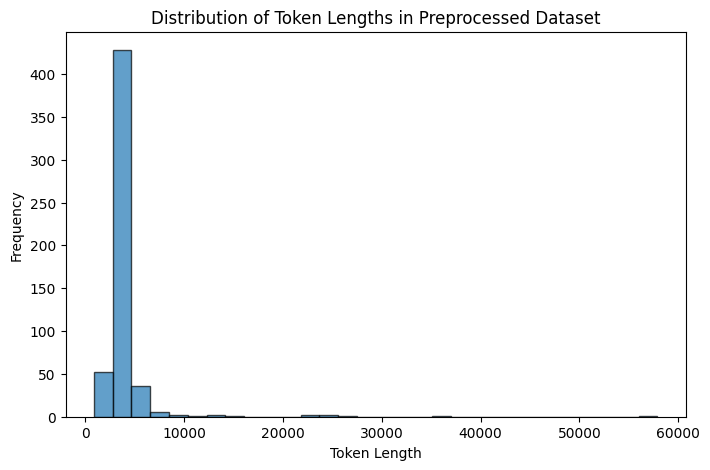

In [12]:
# Inspect the Tokens Output
token_lengths = []

with open(output_path, 'r') as f:
    for line in f:
        convo = json.loads(line)
        convo_texts = []

        for msg in convo:
            if isinstance(msg["content"], str):  # Ensure content is a string
                convo_texts.append(msg["content"])
            elif isinstance(msg["content"], dict):  # Handle cases where content is a dict
                convo_texts.append(json.dumps(msg["content"]))  # Convert dict to JSON string

        convo_text = " ".join(convo_texts)
        token_count = len(tokenizer.encode(convo_text))
        token_lengths.append(token_count)

# Basic statistics
print(f"Total conversations: {len(token_lengths)}")
print(f"Min tokens: {min(token_lengths)}")
print(f"Max tokens: {max(token_lengths)}")
print(f"Mean tokens: {np.mean(token_lengths):.2f}")
print(f"Median tokens: {np.median(token_lengths):.2f}")
print(f"90th percentile: {np.percentile(token_lengths, 90)}")
print(f"95th percentile: {np.percentile(token_lengths, 95)}")

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(token_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths in Preprocessed Dataset")
plt.show()

In [ ]:
# Inspect Conversation blocks exceeding limit

TOKEN_LIMIT = 4096

# Load the conversation blocks and compute token lengths
exceeding_blocks = []
token_lengths = []

with open(output_path, 'r') as f:
    for idx, line in enumerate(f):
        convo = json.loads(line)
        convo_texts = []

        for msg in convo:
            if isinstance(msg["content"], str):  # Ensure content is a string
                convo_texts.append(msg["content"])
            elif isinstance(msg["content"], dict):  # Handle cases where content is a dict
                convo_texts.append(json.dumps(msg["content"]))  # Convert dict to JSON string

        convo_text = " ".join(convo_texts)
        token_count = len(tokenizer.encode(convo_text))
        token_lengths.append(token_count)

        if token_count > TOKEN_LIMIT:
            exceeding_blocks.append((idx, token_count))  # Store block index and token count

# Print results
print(f"Total conversations: {len(token_lengths)}")
print(f"Number of blocks exceeding {TOKEN_LIMIT} tokens: {len(exceeding_blocks)}")

if exceeding_blocks:
    print("\nConversation blocks exceeding limit:")
    for idx, tokens in exceeding_blocks:
        print(f"Block {idx} - Tokens: {tokens}")

In [13]:
# Inspect a Sample
dialog_blocks = []
with open(output_path, 'r') as f:
    for line in f:
        dialog_blocks.append(json.loads(line))  # Parse each line as a JSON object

dialog_blocks[24]

[{'role': 'system',
  'content': "You are David Cameron, a politician in the UK's House of Commons.\n    You are responding to Observations.\n    Respond exactly as David Cameron would speak, \n    staying fully in character and address the observation directly.",
  'agenda': None},
 {'role': 'system',
  'content': "You are David Cameron, a politician in the UK's House of Commons.\n    You are responding to Observations.\n    Respond exactly as David Cameron would speak, \n    staying fully in character and address the observation directly."},
 {'role': 'user',
  'content': 'I should like briefly to focus my remarks on the need for honesty in sentencing and on the effect of overcrowding on the quality of rehabilitation programmes for persistent offenders. First, let us deal with honesty in sentencing and consider the Crime (Sentences) Act 1997. That Act provided for the imposition of mandatory minimum three-year prison sentences for adult domestic burglars thrice convicted. It is true-

# Prepare & Tokenize

In [ ]:
today_date = datetime.datetime.now().strftime("%d %b %Y")

# Load the preprocessed JSONL dataset
with open(output_path, "r") as f:
    raw_data = [json.loads(line) for line in f]

# Convert into a dataset format that follows the guide
formatted_data = []

for convo in raw_data:
    messages = []  # convo is already a list

    for turn in convo:  # ✅ Iterate directly over convo
        if turn["role"] == "system":
            messages.append({"role": "system", "content": turn["content"]})
        elif turn["role"] == "user":
            messages.append({"role": "user", "content": turn["content"]})
        elif turn["role"] == "assistant":
            messages.append({"role": "assistant", "content": turn["content"]})

    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    prompt = prompt.replace(f"Cutting Knowledge Date: December 2023\nToday Date: {today_date}\n\n", "")

    formatted_data.append({"prompt": prompt})

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(formatted_data)

def tokenize_function(example):
    tokens = tokenizer(example['prompt'], 
                       add_special_tokens=False,
                       padding="longest", 
                       truncation=True, 
                       max_length=4096)
    
    tokens['labels'] = [-100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']]

    return tokens

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.save_to_disk("/kaggle/working/tokenized_dataset_DavidCameron")

In [ ]:
tokenized_dataset

In [ ]:
#decoded_text = tokenizer.decode(tokenized_dataset[2]["input_ids"])
#decoded_text

# Visualization & Insights



In [ ]:
# Extract token lengths
token_lengths = [len(sample["input_ids"]) for sample in tokenized_dataset]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=50, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tokenized Sequence Lengths")
plt.axvline(x=4096, color="red", linestyle="dashed", label="Max Length (4096)")
plt.legend()
plt.show()

In [ ]:
# Store original token lengths before truncation
original_lengths = [len(tokenizer.encode(sample["prompt"])) for sample in dataset]  # Raw dataset

# Store tokenized lengths after truncation
truncated_lengths = [len(sample["input_ids"]) for sample in tokenized_dataset_DavidCameron]

# Calculate the number of truncated tokens per sample
tokens_lost = [max(0, orig - trunc) for orig, trunc in zip(original_lengths, truncated_lengths)]

# Compute total percentage of tokens lost
total_tokens = sum(original_lengths)
total_tokens_lost = sum(tokens_lost)
truncation_percentage = (total_tokens_lost / total_tokens) * 100

print(f"Total Tokens: {total_tokens}")
print(f"Total Tokens Lost: {total_tokens_lost}")
print(f"Overall Truncation Percentage: {truncation_percentage:.2f}%")

# Plot histogram of tokens lost per sample
plt.figure(figsize=(8, 5))
plt.hist(tokens_lost, bins=30, color="red", alpha=0.7, edgecolor="black")
plt.xlabel("Number of Tokens Truncated")
plt.ylabel("Number of Samples")
plt.title("Distribution of Tokens Truncated Per Sample")
plt.show()

# Plot percentage of lost tokens
plt.figure(figsize=(6, 5))
plt.pie([total_tokens_lost, total_tokens - total_tokens_lost], 
        labels=["Truncated Tokens", "Retained Tokens"], 
        autopct="%1.1f%%", 
        colors=["red", "green"])
plt.title("Percentage of Truncated Tokens")
plt.show()

In [ ]:
truncated_samples = sum(1 for sample in tokenized_dataset if len(sample["input_ids"]) == 4096)
total_samples = len(tokenized_dataset)

plt.figure(figsize=(6, 5))
plt.pie([truncated_samples, total_samples - truncated_samples], 
        labels=["Truncated", "Not Truncated"], autopct="%1.1f%%", colors=["red", "green"])
plt.title("Percentage of Truncated Samples")
plt.show()

In [ ]:
# Calculate padding ratios
padding_ratios = [(sample["input_ids"].count(tokenizer.pad_token_id) / len(sample["input_ids"])) 
                  for sample in tokenized_dataset]

# Plot distribution of padding percentages
plt.figure(figsize=(8, 5))
plt.hist(padding_ratios, bins=30, color="orange", edgecolor="black", alpha=0.7)
plt.xlabel("Padding Ratio")
plt.ylabel("Frequency")
plt.title("Padding Proportion in Tokenized Samples")
plt.show()

In [ ]:
user_tokens = []
assistant_tokens = []

for sample in tokenized_dataset:
    decoded_text = tokenizer.decode(sample["input_ids"])
    user_tokens.append(decoded_text.count("<|start_header_id|>user"))
    assistant_tokens.append(decoded_text.count("<|start_header_id|>assistant"))

plt.figure(figsize=(8, 5))
plt.hist(user_tokens, bins=30, color="blue", alpha=0.5, label="User Tokens")
plt.hist(assistant_tokens, bins=30, color="green", alpha=0.5, label="Assistant Tokens")
plt.xlabel("Tokens Per Sample")
plt.ylabel("Frequency")
plt.title("Distribution of User vs. Assistant Tokens")
plt.legend()
plt.show()